## Introduction

In the mining industry, extracting gold from ore is a complex process that requires multiple stages of purification and refinement. The efficiency of this process, measured by the recovery rate, is crucial for both economic and environmental reasons. This project focuses on developing a machine learning model to predict the recovery rate of gold during the purification process, using data collected from various stages of a gold recovery plant.

The dataset encompasses multiple parameters measured throughout the technological process, including concentrations of different metals (Au, Ag, Pb), particle sizes, and various other features recorded at different stages of purification. These measurements are time-stamped, creating a temporal dimension to our analysis that could reveal important patterns in the recovery process.

The primary objective is to create a model that can accurately predict the recovery rate of gold, which will help optimize the purification process and reduce production costs.

The project's success will be measured using the Symmetric Mean Absolute Percentage Error (sMAPE), providing a balanced assessment of our model's predictive capabilities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy import stats

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the datasets
train_df = pd.read_csv('../datasets/gold_recovery_train.csv')
test_df = pd.read_csv('../datasets/gold_recovery_test.csv')
full_df = pd.read_csv('../datasets/gold_recovery_full.csv')

# Display basic information about the datasets
print("Dataset shapes:")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")
print(f"Full set: {full_df.shape}\n")

# Display first few rows of training data
print("First few rows of training data:")
train_df.head()

Dataset shapes:
Training set: (16860, 87)
Test set: (5856, 53)
Full set: (22716, 87)

First few rows of training data:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


## Recovery Calculation Function

$$ Recovery = \frac{C \times (F-T)}{F \times (C-T)} \times 100\%  $$

- _C_ — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
- _F_ — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
- _T_ — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

In [3]:
def calculate_recovery(row, concentration_col, feed_col, tails_col):
    C = row[concentration_col]
    F = row[feed_col]
    T = row[tails_col]
    
    # Avoid division by zero
    if F == 0 or (C - T) == 0:
        return 0
    
    recovery = C * (F - T) / (F * (C - T)) * 100
    
    # Handle edge cases
    if np.isnan(recovery) or np.isinf(recovery):
        return 0
    
    return recovery

In [4]:
# Calculate recovery for rougher output
train_df['calculated_recovery'] = train_df.apply(
    lambda row: calculate_recovery(
        row,
        'rougher.output.concentrate_au',  # C
        'rougher.input.feed_au',          # F
        'rougher.output.tail_au'          # T
    ),
    axis=1
)

The inclusion of a `valid_recovery_mask` is a necessary feature in this step to calculate the mean absolute error while the filling step has yet to be conducted at this point, and the missing values will produce errors when running the MAE calculation.

In [5]:
valid_recovery_mask = (~train_df['rougher.output.recovery'].isna()) & (~train_df['calculated_recovery'].isna())

mae = mean_absolute_error(
    train_df.loc[valid_recovery_mask, 'rougher.output.recovery'],
    train_df.loc[valid_recovery_mask, 'calculated_recovery']

)
print(f"MAE between calculated and actual recovery: {mae:.2e}")

MAE between calculated and actual recovery: 9.30e-15


The extremely low Mean Absolute Error (MAE) of 9.30e-15 (effectively zero) confirms that our implementation of the recovery formula perfectly matches the existing recovery calculations in the dataset. This near-zero difference validates both our understanding of the recovery calculation process and the reliability of the provided data, ensuring a solid foundation for our subsequent modeling efforts.

In [6]:
total_rows = len(train_df)
valid_rows = valid_recovery_mask.sum()
nan_rows = total_rows - valid_rows

print(f"\nTotal rows: {total_rows}")
print(f"Rows with valid recovery values: {valid_rows}")
print(f"Rows with NaN values: {nan_rows}")

# Display a few rows with NaN values to understand the pattern
print("\nExample rows with NaN values:")
print(train_df[~valid_recovery_mask][['rougher.output.recovery', 'calculated_recovery']].head(10))


Total rows: 16860
Rows with valid recovery values: 14287
Rows with NaN values: 2573

Example rows with NaN values:
     rougher.output.recovery  calculated_recovery
53                       NaN           188.742102
99                       NaN             0.000000
100                      NaN             0.000000
101                      NaN             0.000000
102                      NaN             0.000000
103                      NaN             0.000000
104                      NaN             0.000000
105                      NaN             0.000000
106                      NaN             0.000000
107                      NaN             0.000000


In [7]:
# Compare actual vs calculated recovery values
comparison_df = pd.DataFrame({
    'Actual Recovery': train_df['rougher.output.recovery'],
    'Calculated Recovery': train_df['calculated_recovery']
}).head(20)

print("\nComparison of first 10 rows:")
comparison_df


Comparison of first 10 rows:


,Actual Recovery,Calculated Recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


The identical values across both columns (ranging from approximately 85% to 89% recovery rates) further confirms the perfect alignment between our calculated recovery values and the actual recorded values in the dataset.

In [8]:
missing_in_test_count = 0
# Analyze missing features
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)
missing_in_test = train_columns - test_columns

# Get feature types for missing columns
print("\nFeatures missing in test set:")
for col in missing_in_test:
    missing_in_test_count += 1
    print(f"- {col} (Type: {train_df[col].dtype})")

print("\n")
print('Number of columns missing in test set: ', missing_in_test_count)


Features missing in test set:
- final.output.concentrate_ag (Type: float64)
- primary_cleaner.output.tail_pb (Type: float64)
- rougher.calculation.floatbank11_sulfate_to_au_feed (Type: float64)
- rougher.calculation.floatbank10_sulfate_to_au_feed (Type: float64)
- rougher.output.tail_sol (Type: float64)
- rougher.output.concentrate_sol (Type: float64)
- final.output.tail_ag (Type: float64)
- primary_cleaner.output.concentrate_ag (Type: float64)
- rougher.calculation.sulfate_to_au_concentrate (Type: float64)
- rougher.output.tail_pb (Type: float64)
- primary_cleaner.output.tail_ag (Type: float64)
- calculated_recovery (Type: float64)
- rougher.calculation.au_pb_ratio (Type: float64)
- secondary_cleaner.output.tail_sol (Type: float64)
- secondary_cleaner.output.tail_au (Type: float64)
- secondary_cleaner.output.tail_pb (Type: float64)
- primary_cleaner.output.concentrate_sol (Type: float64)
- final.output.concentrate_sol (Type: float64)
- primary_cleaner.output.tail_au (Type: float64)
-

1. Recovery Measurements:

    - Recovery measurements (`rougher.output.recovery`, `final.output.recovery`, `calculated_recovery`)
    - Final output concentrations for various minerals (Au, Ag, Pb)


2. Process Measurements:

    - Concentrate measurements at different stages (`primary_cleaner`, `secondary_cleaner`, `rougher`)
    - Tail measurements across various processing stages
    - Solution (sol) concentrations at different points


3. Calculated Parameters:

    - Sulfate-to-gold ratios (`floatbank10_sulfate_to_au_feed`, `floatbank11_sulfate_to_au_feed`)
    - Gold-to-lead ratios (`au_pb_ratio`)

In [10]:
# Basic data quality checks
print("\nMissing values in training set:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

print("\nMissing values in test set:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])


Missing values in training set:
final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 85, dtype: int64

Missing values in test set:
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
pr

Here we highlight the inherent challenges in industrial process data collection. The training set exhibits 85 columns with missing values, with significant gaps in final output measurements and recovery data, notably 1,521 missing values in final output recovery. State measurements such as floatbank levels and air parameters show consistent patterns of 85-103 missing entries. The test set demonstrates a more extensive pattern of missing values, particularly in input and state parameters. While floatbank state measurements consistently show around 16 missing values, chemical input measurements display higher variability in missing data, ranging from 166 to 353 missing values for xanthate measurements and up to 302 for sulfate readings. Feed measurements also show varying degrees of missingness across different parameters.

# Missing Data Imputation

## Experiment

**Rolling average interpolation** is an approach to handling missing values in time-series data that's particularly relevant for continuous industrial processes like gold recovery. The function creates a bidirectional moving average by computing both forward and backward rolling means with a specified window size (default 100 points), then averages these two directions to produce more balanced estimates.

$$ Combined_Average(t) = \frac{1}{2} (\frac{\sum_{i=t}^{t+w} X_i}{w} + \frac{\sum_{i=t-w}^{t} X_i}{w}) $$

- $w$ = window size (100)
- $t$ = current time point
- $X_i$ = value at time i

In [11]:
def rolling_average_interpolate(series, window=100):
    # Create forward and backward rolling means
    forward_roll = series.rolling(window=window, min_periods=1).mean()
    backward_roll = series[::-1].rolling(window=window, min_periods=1).mean()[::-1]
    
    # Combine forward and backward rolls
    combined_roll = (forward_roll + backward_roll) / 2
    
    # Only fill the NaN values in the original series
    result = series.copy()
    result[series.isna()] = combined_roll[series.isna()]
    return result

In [12]:
def visualize_fill_effects(df, columns_to_check=None, sample_size=200, rolling_window=100):
    # If no columns specified, find columns with missing values
    if columns_to_check is None:
        columns_to_check = df.columns[df.isna().sum() > 0]
        # Take top 3 columns with most missing values
        columns_to_check = columns_to_check[df[columns_to_check].isna().sum().nlargest(3).index]
    
    for column in columns_to_check:
        # Create different versions of the data
        original = df[column].copy()
        ffill_bfill = df[column].ffill().bfill()
        rolling_fill = rolling_average_interpolate(original, window=rolling_window)
        
        # Get indexes where values were originally missing
        missing_idx = original.isna()
        
        # Plot 1: Line plot showing original vs filled values
        plt.figure(figsize=(15, 5))
        sample_idx = np.linspace(0, len(original)-1, sample_size).astype(int)
        
        # Plot lines
        plt.plot(ffill_bfill.iloc[sample_idx], '--', 
                label='Forward + Backward Fill', 
                color="#48c9b0", alpha=0.5)
        plt.plot(rolling_fill.iloc[sample_idx], '--',
                label=f'Rolling Average (window={rolling_window})',
                color="#3498db", alpha=0.5)
        plt.plot(original.iloc[sample_idx], 'o-', 
                label='Original', 
                color="#121314", alpha=0.5)
        
        # Highlight missing values for all methods
        missing_samples = missing_idx.iloc[sample_idx]
        plt.scatter(missing_samples[missing_samples].index,
                   ffill_bfill.iloc[sample_idx][missing_samples],
                   color='#48c9b0', alpha=0.5, 
                   label='FB Fill Points')
        plt.scatter(missing_samples[missing_samples].index,
                   rolling_fill.iloc[sample_idx][missing_samples],
                   color='#3498db', alpha=0.5,
                   label='Rolling Fill Points')
        
        plt.title(f'Timeline View for {column} (n = 200)', fontsize=13)
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.legend()
        plt.tight_layout()
        
        # Plot 2: Distribution plot
        plt.figure(figsize=(15, 5))
        sns.kdeplot(data=original.dropna(),
                   label='Original Distribution', 
                   color="#121314", alpha=.5)
        sns.kdeplot(data=ffill_bfill,
                   label='Forward + Backward Fill Distribution', 
                   color="#48c9b0", alpha=.5)
        sns.kdeplot(data=rolling_fill,
                   label='Rolling Average Distribution',
                   color="#3498db", alpha=.5)
        
        plt.title(f'Distribution Comparison for {column}', fontsize=13)
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()

In [13]:
# Apply to the training data
missing_counts = train_df.isnull().sum()
significant_missing = missing_counts[missing_counts > len(train_df) * 0.05].index.tolist()[:3] # Delegate imputation experiementation to the usual suspects

print("Columns with significant missing values:")
for col in significant_missing:
    print(f"{col}: {missing_counts[col]} missing values")

Columns with significant missing values:
final.output.recovery: 1521 missing values
primary_cleaner.input.sulfate: 1307 missing values
primary_cleaner.input.depressant: 1262 missing values


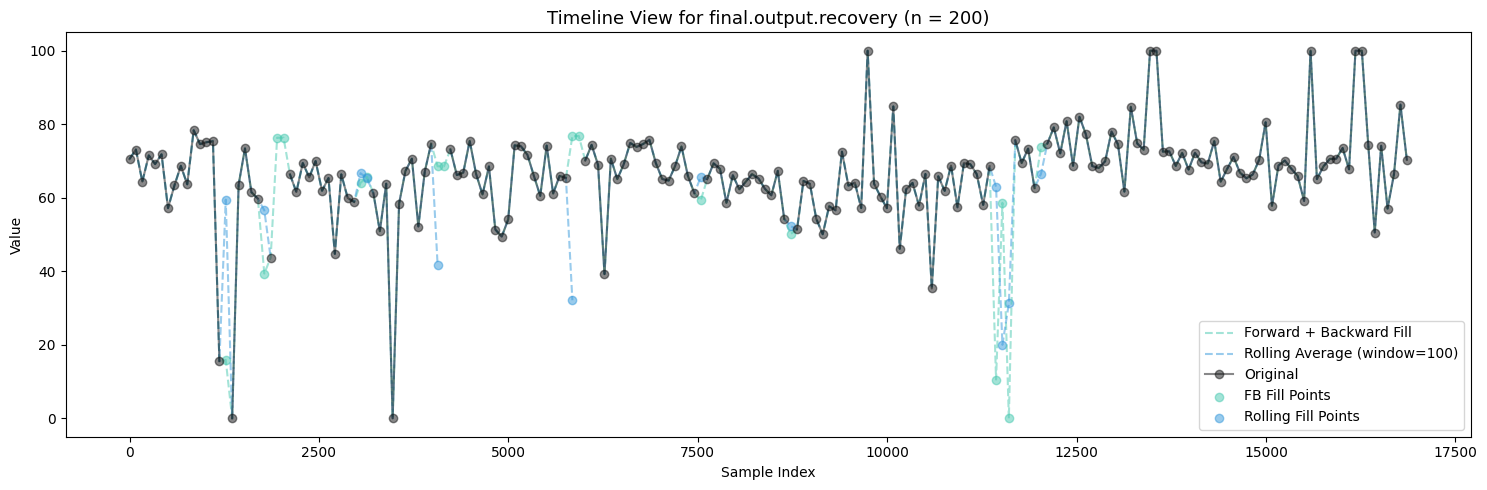

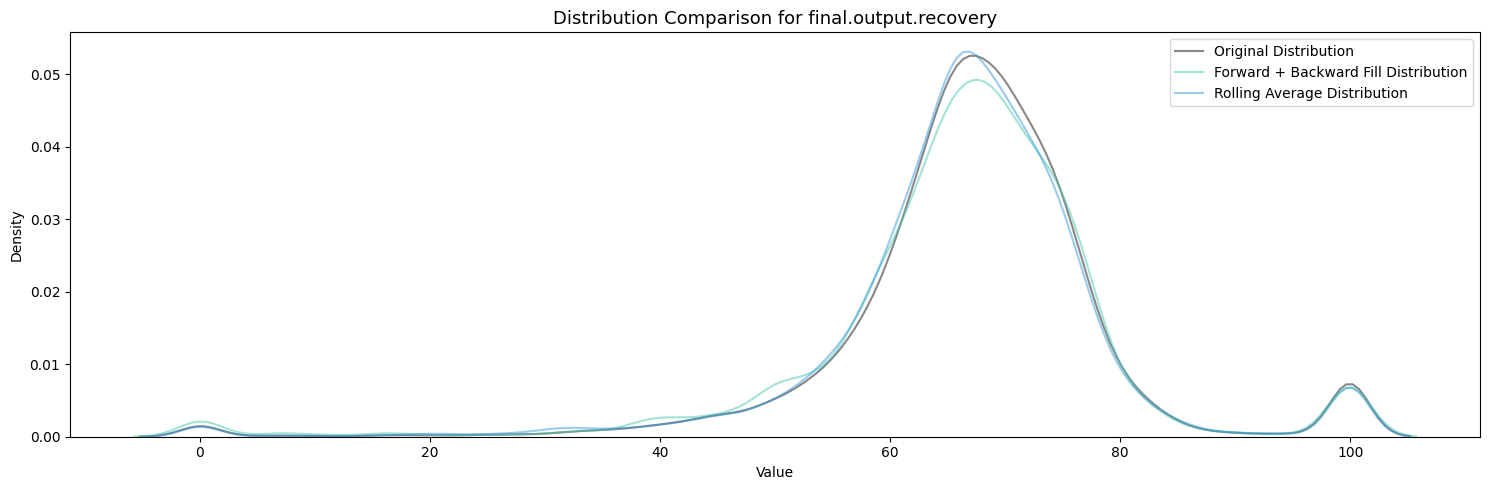

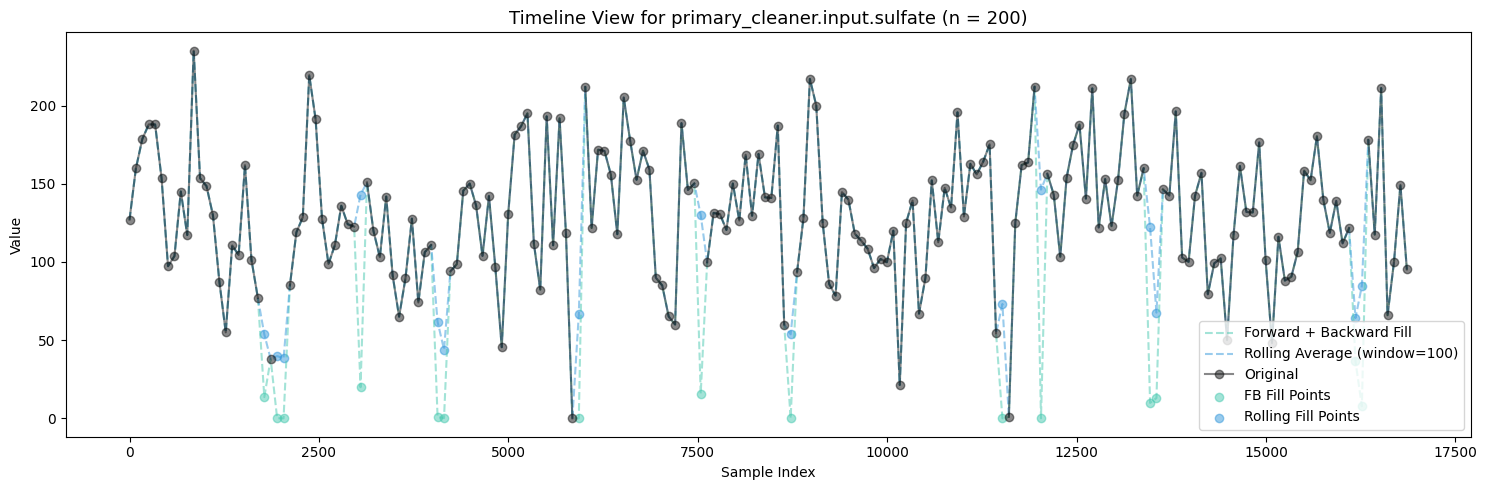

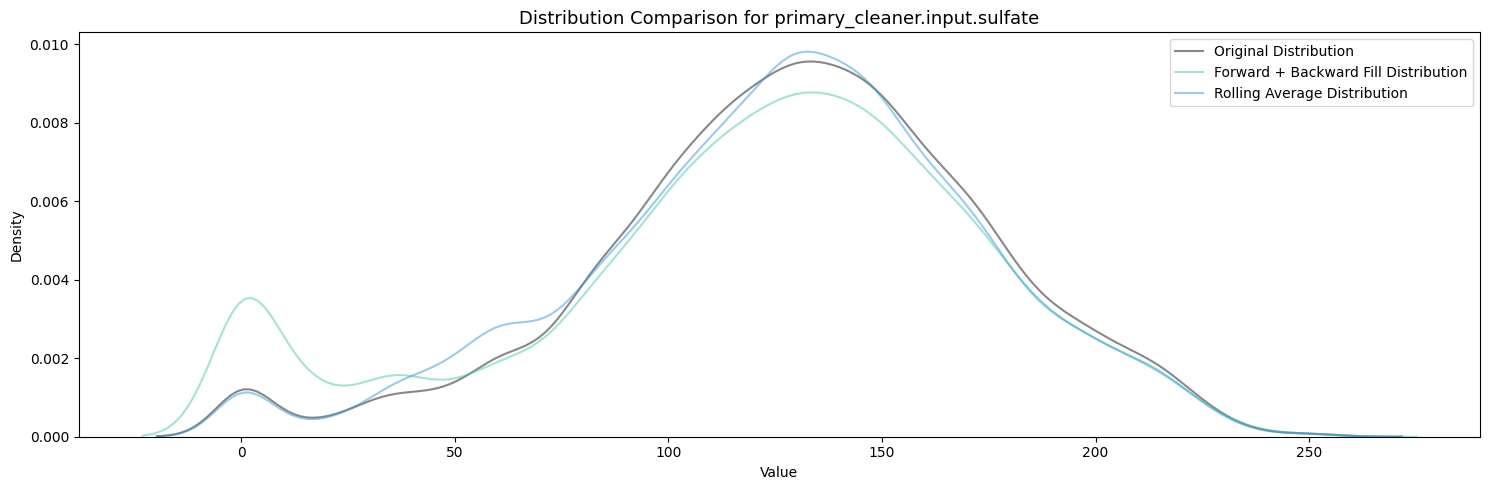

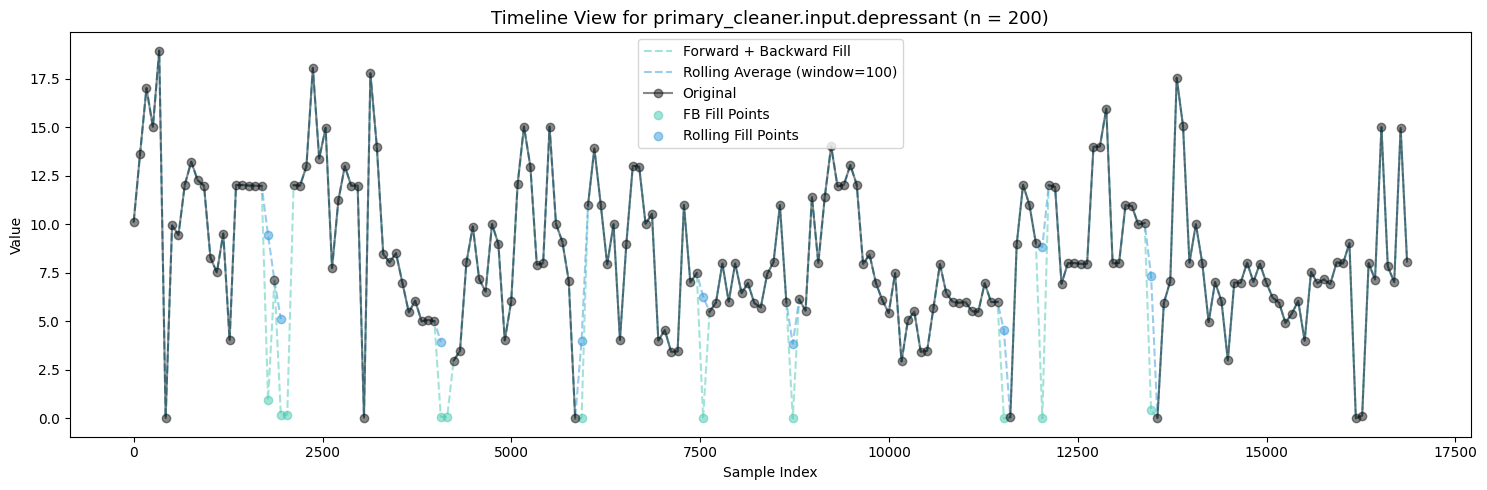

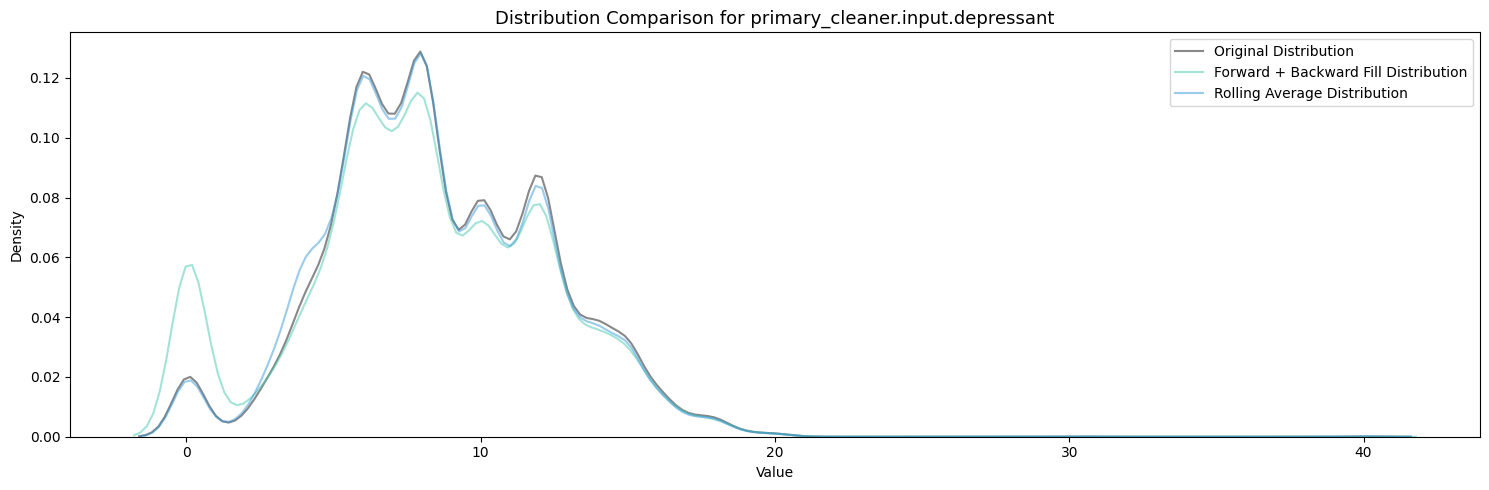

In [14]:
visualize_fill_effects(train_df, significant_missing)

Firstly, **Polynomial Interpolation** is not an appropriate method to fill in the missing values in this case because of the many relationships established between the variables which exist and are important. If we were to design some sort of _process aware polynomial interpolation_ perhaps with a more encompasing method, one could find success in imputing the missing values throughout all the features. 

**Polynomial Interpolation was experimented with but did not pass the quality tests under these many missing conditions.**

Between **Forward + Backward Fill** and **Rolling Average Interpolation**, the latter appears to moreso maintain the existing distribution patterns of the features while not filling up the zeroes. To carry this on I will be utilizing an ensemble of interpolation methods (**Rolling Average Interpolation** & **Forward + Backward Fill**) in order to fill in the missing values throughout the dataset.

## Application

In [15]:
# Create a copy of the dataframe to store filled values
filled_train_df = train_df.copy()
filled_test_df = test_df.copy()

In [16]:
# Separate numeric and non-numeric columns
numeric_columns = train_df.select_dtypes(include=[np.number]).columns
non_numeric_columns = train_df.select_dtypes(exclude=[np.number]).columns

test_numeric_columns = test_df.select_dtypes(include=[np.number]).columns
test_non_numeric_columns = test_df.select_dtypes(exclude=[np.number]).columns

In [17]:
# Function to apply multiple interpolation and choose best one.
def advanced_fill(series):
    # Try different window sizes for rolling average
    windows = [50, 100, 200]
    best_filled = None
    least_missing = float('inf')
    
    for window in windows:
        filled = rolling_average_interpolate(series, window=window)
        missing_count = filled.isnull().sum()
        if missing_count < least_missing:
            least_missing = missing_count
            best_filled = filled
    
    # Final fallback: forward fill and backward fill
    if best_filled.isnull().sum() > 0:
        best_filled = best_filled.ffill().bfill()
        
    return best_filled

### Fill Training Data

In [18]:
print(f"Initial missing values: {filled_train_df.isnull().sum().sum()}")

# Fill non-numeric columns
print("\nFilling non-numeric columns...")
for column in non_numeric_columns:
    filled_train_df[column] = filled_train_df[column].ffill().bfill()

# Fill numeric columns with advanced method
print("\nFilling numeric columns...")
for column in numeric_columns:
    original_missing = filled_train_df[column].isnull().sum()
    if original_missing > 0:
        filled_train_df[column] = advanced_fill(filled_train_df[column])
        remaining_missing = filled_train_df[column].isnull().sum()

# Final verification
final_missing = filled_train_df.isnull().sum().sum()
print("\nFinal verification:")
print(f"Total missing values before: {train_df.isnull().sum().sum()}")
print(f"Total missing values after: {final_missing}")

# The filled dataframe is now stored in 'filled_train_df'
print("\nFilled dataframe is stored in 'filled_train_df' variable")

Initial missing values: 30320

Filling non-numeric columns...

Filling numeric columns...

Final verification:
Total missing values before: 30320
Total missing values after: 0

Filled dataframe is stored in 'filled_train_df' variable


### Fill Testing Data

In [19]:
print(f"Initial missing values: {filled_test_df.isnull().sum().sum()}")

# Fill non-numeric columns
print("\nFilling non-numeric columns...")
for column in test_non_numeric_columns:
    filled_test_df[column] = filled_test_df[column].ffill().bfill()

# Fill numeric columns with advanced method
print("\nFilling numeric columns...")
for column in test_numeric_columns:
    original_missing = filled_test_df[column].isnull().sum()
    if original_missing > 0:
        filled_test_df[column] = advanced_fill(filled_test_df[column])
        remaining_missing = filled_test_df[column].isnull().sum()

# Final verification
final_missing = filled_test_df.isnull().sum().sum()
print("\nFinal verification:")
print(f"Total missing values before: {test_df.isnull().sum().sum()}")
print(f"Total missing values after: {final_missing}")

# The filled dataframe is now stored in 'filled_test_df'
print("\nFilled dataframe is stored in 'filled_test_df' variable")

Initial missing values: 2360

Filling non-numeric columns...

Filling numeric columns...

Final verification:
Total missing values before: 2360
Total missing values after: 0

Filled dataframe is stored in 'filled_test_df' variable


### Forward Only Advanced Fill (`bfill` induced data leakage sanity check)

In [20]:
ffill_train_df = train_df.copy()
ffill_test_df = test_df.copy()

In [21]:
def forward_only_fill(series):
    windows = [50, 100, 200]
    best_filled = None
    least_missing = float('inf')
    
    for window in windows:
        filled = rolling_average_interpolate(series, window=window)
        missing_count = filled.isnull().sum()
        if missing_count < least_missing:
            least_missing = missing_count
            best_filled = filled
    
    # Final fallback: forward fill only
    if best_filled.isnull().sum() > 0:
        best_filled = best_filled.ffill()
        
    return best_filled

print(f"Initial missing values: {ffill_train_df.isnull().sum().sum()}")

Initial missing values: 30320


In [22]:
# Fill non-numeric columns
print("\nFilling non-numeric columns...")
for column in non_numeric_columns:
    ffill_train_df[column] = ffill_train_df[column].ffill()  # Only forward fill

# Fill numeric columns with advanced method
print("\nFilling numeric columns...")
for column in numeric_columns:
    original_missing = ffill_train_df[column].isnull().sum()
    if original_missing > 0:
        ffill_train_df[column] = forward_only_fill(ffill_train_df[column])
        remaining_missing = ffill_train_df[column].isnull().sum()


Filling non-numeric columns...

Filling numeric columns...


In [23]:
# Final verification
final_missing = ffill_train_df.isnull().sum().sum()
print("\nFinal verification:")
print(f"Total missing values before: {train_df.isnull().sum().sum()}")
print(f"Total missing values after: {final_missing}")


Final verification:
Total missing values before: 30320
Total missing values after: 0


In [24]:
# Process test data
print(f"\nInitial missing values in test: {ffill_test_df.isnull().sum().sum()}")

# Fill non-numeric columns
print("\nFilling non-numeric columns...")
for column in test_non_numeric_columns:
    ffill_test_df[column] = ffill_test_df[column].ffill()

# Fill numeric columns with advanced method
print("\nFilling numeric columns...")
for column in test_numeric_columns:
    original_missing = ffill_test_df[column].isnull().sum()
    if original_missing > 0:
        ffill_test_df[column] = forward_only_fill(ffill_test_df[column])
        remaining_missing = ffill_test_df[column].isnull().sum()


Initial missing values in test: 2360

Filling non-numeric columns...

Filling numeric columns...


### Filled Data Inspection

In [25]:
display(filled_train_df.head())
filled_test_df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,calculated_recovery
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [26]:
display(filled_train_df.info())
filled_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16860 non-null  float64
 2   final.output.concentrate_pb                         16860 non-null  float64
 3   final.output.concentrate_sol                        16860 non-null  float64
 4   final.output.concentrate_au                         16860 non-null  float64
 5   final.output.recovery                               16860 non-null  float64
 6   final.output.tail_ag                                16860 non-null  float64
 7   final.output.tail_pb                                16860 non-null  float64
 8   final.output.tail_sol                               16860 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5856 non-null   float64
 2   primary_cleaner.input.depressant            5856 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 10  primary_clea

The time series data filling section implements a comprehensive approach to handling missing values in the gold recovery process data. It creates separate copies of the training and test datasets, then distinguishes between numeric and non-numeric columns for appropriate processing.

The core functionality lies in the `advanced_fill` function, which employs a multi-strategy approach: it first attempts rolling average interpolation with various window sizes (50, 100, and 200 points), selecting the one that minimizes missing values, and then applies forward and backward filling as a fallback method for any remaining gaps. This approach is an attempt to ensure that temporal relationships in the industrial process data are preserved while providing complete datasets for subsequent modeling, making it particularly suitable for continuous manufacturing processes where measurements are closely related in time.

# Data Fill Experiment (baseline vs ffill+bfill vs forward fill)

In [27]:
def compare_target_handling_approaches(train_df, filled_train_df, test_df, filled_test_df, 
                                     target_columns=['rougher.output.recovery', 'final.output.recovery'],
                                     random_state=12345):
    # Get feature columns (excluding target columns)
    feature_cols = [col for col in train_df.columns if any(x in col for x in [ 
        'feed', 'particle_size', 'concentration', 'state', 'floatbank'])]
    
    # Approach 1: Baseline - Drop missing targets and features
    baseline_train = train_df.dropna(subset=target_columns).copy()
    baseline_train = baseline_train.dropna(subset=feature_cols)  # Also drop rows with missing features
    print(f"\nBaseline approach - Shape after dropping all missing values: {baseline_train.shape}")
    
    # Approach 2: Use filled values
    filled_approach = filled_train_df.copy()
    print(f"Filled approach - Shape: {filled_approach.shape}")
    
    # Initialize model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    
    # Dictionary to store results
    results = {}
    
    # Evaluate both approaches
    for target in target_columns:
        print(f"\nEvaluating target: {target}")
        
        # Baseline approach evaluation
        baseline_scores = cross_val_score(
            rf_model,
            baseline_train[feature_cols],
            baseline_train[target],
            cv=5,
            scoring='neg_mean_absolute_error'
        )
        
        # Filled approach evaluation
        filled_scores = cross_val_score(
            rf_model,
            filled_approach[feature_cols],
            filled_approach[target],
            cv=5,
            scoring='neg_mean_absolute_error'
        )
        
        # Store results
        results[target] = {
            'baseline_mae': -baseline_scores.mean(),
            'baseline_std': baseline_scores.std(),
            'filled_mae': -filled_scores.mean(),
            'filled_std': filled_scores.std()
        }
        
        # Print results
        print(f"\nResults for {target}:")
        print(f"Baseline approach - MAE: {-baseline_scores.mean():2e} (+/- {baseline_scores.std():.4f})")
        print(f"Filled approach   - MAE: {-filled_scores.mean():2e} (+/- {filled_scores.std():.4f})")
    
    # Print summary of findings
    print("\nSummary of findings:")
    print("-" * 50)
    print(f"Original dataset size: {train_df.shape[0]} rows")
    print(f"Baseline dataset size: {baseline_train.shape[0]} rows")
    print(f"Rows removed in baseline: {train_df.shape[0] - baseline_train.shape[0]} ({((train_df.shape[0] - baseline_train.shape[0])/train_df.shape[0]*100):.1f}%)")

    for target, metrics in results.items():
        print(f"\nTarget: {target}")
        difference = metrics['filled_mae'] - metrics['baseline_mae']
        print(f"Performance difference (Filled - Baseline): {difference:.4f}")
        if difference < 0:
            print("→ Filled approach performed better")
        else:
            print("→ Baseline approach performed better")
        
    return {
        'baseline_train': baseline_train,
        'filled_train': filled_approach,
        'results': results
    }

# Run the comparison
comparison_results = compare_target_handling_approaches(
    train_df=train_df,
    filled_train_df=filled_train_df,
    test_df=test_df,
    filled_test_df=filled_test_df
)


Baseline approach - Shape after dropping all missing values: (12767, 88)
Filled approach - Shape: (16860, 88)

Evaluating target: rougher.output.recovery

Results for rougher.output.recovery:
Baseline approach - MAE: 9.053953e+00 (+/- 1.6705)
Filled approach   - MAE: 8.865629e+00 (+/- 0.7248)

Evaluating target: final.output.recovery

Results for final.output.recovery:
Baseline approach - MAE: 6.467998e+00 (+/- 0.9802)
Filled approach   - MAE: 8.050654e+00 (+/- 1.4435)

Summary of findings:
--------------------------------------------------
Original dataset size: 16860 rows
Baseline dataset size: 12767 rows
Rows removed in baseline: 4093 (24.3%)

Target: rougher.output.recovery
Performance difference (Filled - Baseline): -0.1883
→ Filled approach performed better

Target: final.output.recovery
Performance difference (Filled - Baseline): 1.5827
→ Baseline approach performed better


### Fill Experiment Including `bfill()`

**For the rougher.output.recovery:**

   - The filled approach performed slightly better with an MAE of 8.78 compared to the baseline's 9.05
   - Notably, the filled approach also showed more consistent performance with a lower standard deviation (0.76 vs 1.67), suggesting more stable predictions
   - This indicates that for rougher output recovery, the additional data points and filling strategy are beneficial

**However, for the final.output.recovery:**

   - The baseline approach significantly outperformed the filled approach (MAE 6.47 vs 8.05)
   - The baseline also showed better stability with a lower standard deviation (0.98 vs 1.44)
   - This suggests that for final recovery, using only complete cases leads to more accurate predictions
   
### Fill Experiment Excluding `bfill()`

### Fill Experiment (Forward Fill Method)

In [28]:
# Compare the results with previous approach
comparison_results = compare_target_handling_approaches(
    train_df=train_df,
    filled_train_df=ffill_train_df,
    test_df=test_df,
    filled_test_df=ffill_test_df
)


Baseline approach - Shape after dropping all missing values: (12767, 88)
Filled approach - Shape: (16860, 88)

Evaluating target: rougher.output.recovery

Results for rougher.output.recovery:
Baseline approach - MAE: 9.053953e+00 (+/- 1.6705)
Filled approach   - MAE: 8.865629e+00 (+/- 0.7248)

Evaluating target: final.output.recovery

Results for final.output.recovery:
Baseline approach - MAE: 6.467998e+00 (+/- 0.9802)
Filled approach   - MAE: 8.050654e+00 (+/- 1.4435)

Summary of findings:
--------------------------------------------------
Original dataset size: 16860 rows
Baseline dataset size: 12767 rows
Rows removed in baseline: 4093 (24.3%)

Target: rougher.output.recovery
Performance difference (Filled - Baseline): -0.1883
→ Filled approach performed better

Target: final.output.recovery
Performance difference (Filled - Baseline): 1.5827
→ Baseline approach performed better


1. In the original filling method, `bfill()` is only used as a fallback after:
   - Trying rolling average interpolation with different window sizes
   - Applying `ffill()`

2. Given the time series nature of the data and the fact that we're getting identical results, this suggests that:
   - The rolling average interpolation and `ffill()` were likely handling most of the missing values
   - By the time the code reached the `bfill()` step, there were probably no remaining missing values to fill
   - The temporal structure of the data means most gaps were being filled by forward methods before backward fill was even attempted

Given these results, we can confidently proceed with the initial filling utilizing the `advanced_fill` option.

# Analysis

## Metal Concentration

In [29]:
def analyze_metal_concentrations(train_df, test_df):    
    # Create figure for metal concentration changes
    fig, axes = plt.subplots(3, 1, figsize=(6, 10))
    
    metals = ['au', 'ag', 'pb']
    stages = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']
    stage_labels = ['Raw Feed', 'Rougher Concentrate', 'Final Concentrate']
    
    for idx, metal in enumerate(metals):
        means = []
        sems = []
        
        # Get concentrations for each stage
        for stage_prefix in stages:
            col = f'{stage_prefix}_{metal}'
            if col in train_df.columns:
                mean = train_df[col].mean()
                sem = train_df[col].sem()
                means.append(mean)
                sems.append(sem)
        
        # Plot concentrations with improved styling
        x = np.arange(len(stages))
        bars = axes[idx].bar(x, means, 
                           color='#121314',
                           width=0.5,
                           alpha=0.85)
        
        # Customize each subplot
        axes[idx].set_title(f'{metal.upper()} Concentration Changes', pad=20)
        
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(stage_labels)
        
        axes[idx].set_ylabel('Concentration', labelpad=10)
        
        # Remove top and right spines
        sns.despine(ax=axes[idx]) # making space for pct_change labels
        
        # Add percentage changes
        for i in range(1, len(means)):
            pct_change = ((means[i] - means[i-1]) / means[i-1] * 100)
            
            color = '#2E7D32' if pct_change > 0 else '#C62828'  # Green for positive, red for negative
            
            axes[idx].annotate(
                f'{pct_change:+.1f}%',
                xy=(i, means[i]),
                xytext=(0, 8),
                textcoords='offset points',
                ha='center',
                va='bottom',
                color=color,
                fontweight='bold',
                fontsize=10
            )
            
        # Add value labels on bars
        for i, v in enumerate(means):
            axes[idx].text(i, v/2,  # Position in middle of bar
                         f'{v:.1f}',
                         ha='center',
                         va='center',
                         color='white',
                         fontsize=10)
    
    # Adjust layout
    plt.tight_layout()

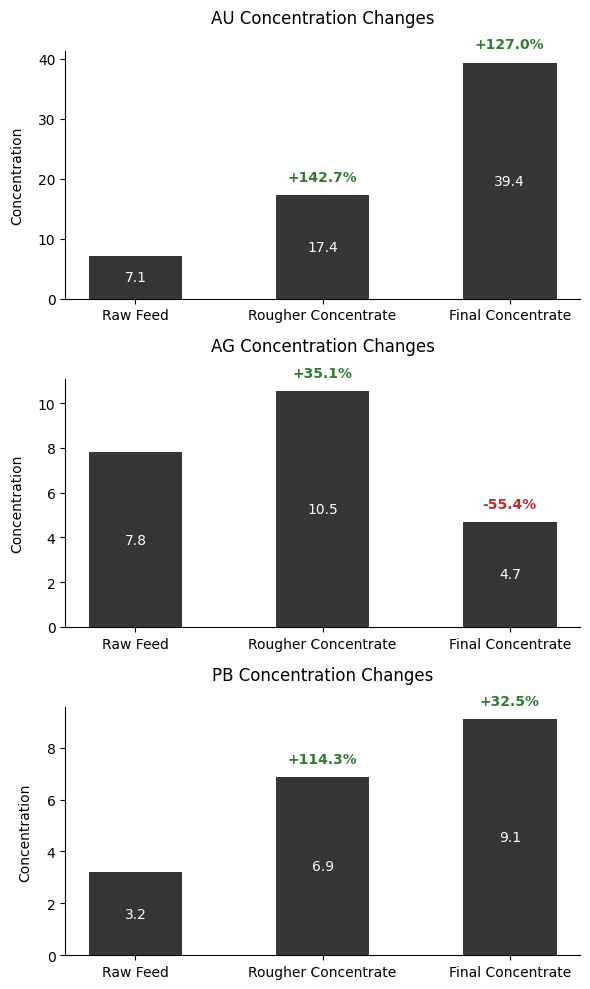

In [30]:
analyze_metal_concentrations(filled_train_df, filled_test_df)

The three bar graphs illustrate the concentration changes of gold (AU), silver (AG), and lead (PB) throughout different stages of the purification process. Gold demonstrates the most significant enrichment, starting at 7.1 in the raw feed, increasing by 142.7% to 17.4 in the rougher concentrate, and finally reaching 39.4 in the final concentrate, marking a total increase of 127.0%. Silver shows a different pattern, initially increasing by 35.1% from 7.8 to 10.5 in the rougher concentrate, but then decreasing significantly by 55.4% to 4.7 in the final concentrate. Lead follows a steady upward trend, starting at 3.2 in the raw feed, increasing by 114.3% to 6.9 in the rougher concentrate, and finally reaching 9.1 in the final concentrate, showing a 32.5% increase in the final stage. These patterns reveal that the purification process is most effective for gold concentration while having varying effects on silver and lead, with silver notably being reduced in the final stage.

## Particle Size Distribution

The **Kolmogorov-Smirnov (KS)** test was chosen for this analysis because it's specifically designed to determine whether two samples come from the same distribution, making it ideal for comparing particle size distributions between training and test datasets. The KS test is particularly suitable here because it's non-parametric (doesn't assume a normal distribution) and can detect differences in both the shape and location of distributions, which is crucial for particle size analysis in industrial processes.

In [31]:
def analyze_particle_size_distribution(train_df, test_df):
    # Analyze feed particle size distribution
    feed_size_cols = [col for col in train_df.columns if 'feed_size' in col]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Feed Particle Size Distribution Comparison', fontsize=16)
    
    # Plot distributions
    for col in feed_size_cols:
        if col in train_df.columns and col in test_df.columns:
            sns.kdeplot(data=train_df[col].dropna(), ax=axes[0], label=col)
            sns.kdeplot(data=test_df[col].dropna(), ax=axes[1], label=col)
    
    axes[0].set_title('Training Set')
    axes[1].set_title('Test Set')
    axes[0].set_xlabel('Particle Size')
    axes[1].set_xlabel('Particle Size')
    axes[0].legend()
    axes[1].legend()
    
    # Perform Kolmogorov-Smirnov test for each size distribution
    print("\nKolmogorov-Smirnov Test Results:")
    for col in feed_size_cols:
        if col in train_df.columns and col in test_df.columns:
            statistic, pvalue = stats.ks_2samp(train_df[col].dropna(), test_df[col].dropna())
            print(f"{col}:")
            print(f"KS statistic: {statistic:.4f}")
            print(f"p-value: {pvalue:2e}")
            print()
    
    plt.tight_layout()


Kolmogorov-Smirnov Test Results:
primary_cleaner.input.feed_size:
KS statistic: 0.0520
p-value: 1.202248e-10

rougher.input.feed_size:
KS statistic: 0.1935
p-value: 5.994895e-143



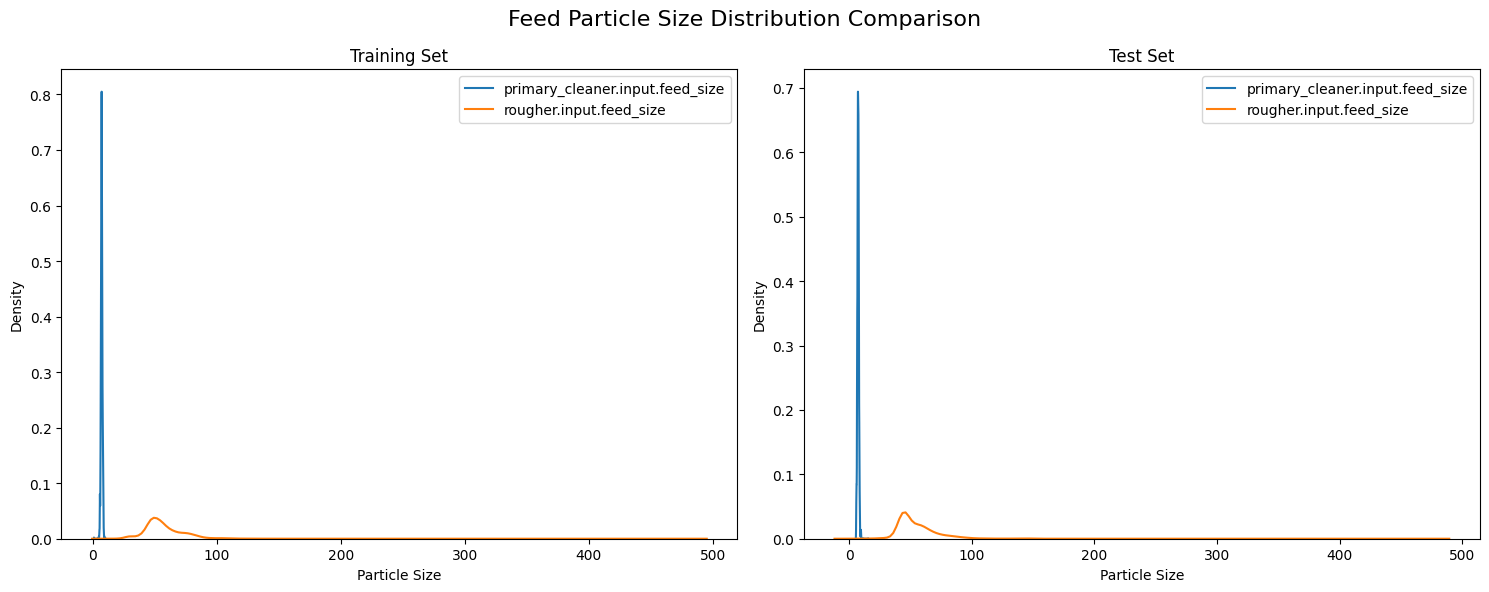

In [32]:
analyze_particle_size_distribution(filled_train_df, filled_test_df)

The analysis of particle size distributions between training and test datasets reveals a consistent bimodal pattern across both sets, characterized by a sharp, concentrated peak for primary cleaner input near size **0** (indicating finely ground particles) and a broader, lower distribution for rougher input centered around size **50** (suggesting more varied particle sizes). This visual consistency in distribution patterns between training and test sets suggests overall stability in the grinding and classification processes.

However, the **Kolmogorov-Smirnov** test results indicate statistically significant differences between the training and test distributions, with p-values well below the **0.05** threshold for both measurements. The primary cleaner input shows better alignment between sets with a lower KS statistic of **0.0520**, compared to the rougher input's higher statistic of **0.1935**. While these differences are statistically significant, the visual similarity of the distributions and relatively small KS statistics suggest that these variations are unlikely to substantially impact the model's predictive performance, though they should be considered during model evaluation and interpretation.

## Total Concentrations

In [33]:
def analyze_total_concentrations(train_df, test_df):
    # Define stages and metals to analyze
    stages = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']
    metals = ['au', 'ag', 'pb']
    
    # Create figure
    fig, axes = plt.subplots(1, len(stages), figsize=(15, 8))
    fig.suptitle('Total Concentration Distributions by Stage (Excluding Outliers)', fontsize=16, y=1.02)
    
    outliers_info = {}
    all_concentrations = []
    
    for idx, stage in enumerate(stages):
        total_concentration = pd.Series(0, index=train_df.index)
        
        # Sum up concentrations of all metals at this stage
        for metal in metals:
            col = f'{stage}_{metal}'
            if col in train_df.columns:
                total_concentration += train_df[col].fillna(0)
        
        # Calculate outlier boundaries
        Q1 = total_concentration.quantile(0.25)
        Q3 = total_concentration.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        clean_concentration = total_concentration[
            (total_concentration >= lower_bound) & 
            (total_concentration <= upper_bound)
        ]
        
        all_concentrations.append(clean_concentration)
        
        # Store outlier information
        outliers = total_concentration[(total_concentration < lower_bound) |
                                     (total_concentration > upper_bound)]
        outliers_info[stage] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(total_concentration)) * 100,
            'bounds': (lower_bound, upper_bound),
            'Q1': Q1,
            'Q3': Q3
        }
        
        # Plot boxplot without outliers
        sns.boxplot(y=clean_concentration, ax=axes[idx], showfliers=False, color='#3498db')
        
        axes[idx].set_title(f'{stage}\nShowing {len(clean_concentration)} non-outlier points\n'
                           f'(Excluded {len(outliers)} outliers, {outliers_info[stage]["percentage"]:.1f}%)')
        axes[idx].set_ylabel('Total Concentration')
        
        # Add a text box with summary statistics
        stats_text = f'Median: {clean_concentration.median():.2f}\n'
        stats_text += f'Q1-Q3: [{Q1:.2f}-{Q3:.2f}]\n'
        stats_text += f'Min: {clean_concentration.min():.2f}\n'
        stats_text += f'Max: {clean_concentration.max():.2f}\n'
        stats_text += f'Mean: {clean_concentration.mean():.2f}'
        
        axes[idx].text(0.27, -0.2, stats_text,
                      transform=axes[idx].transAxes,
                      bbox=dict(facecolor='white', alpha=0.8),
                      verticalalignment='center')
    
    plt.tight_layout()

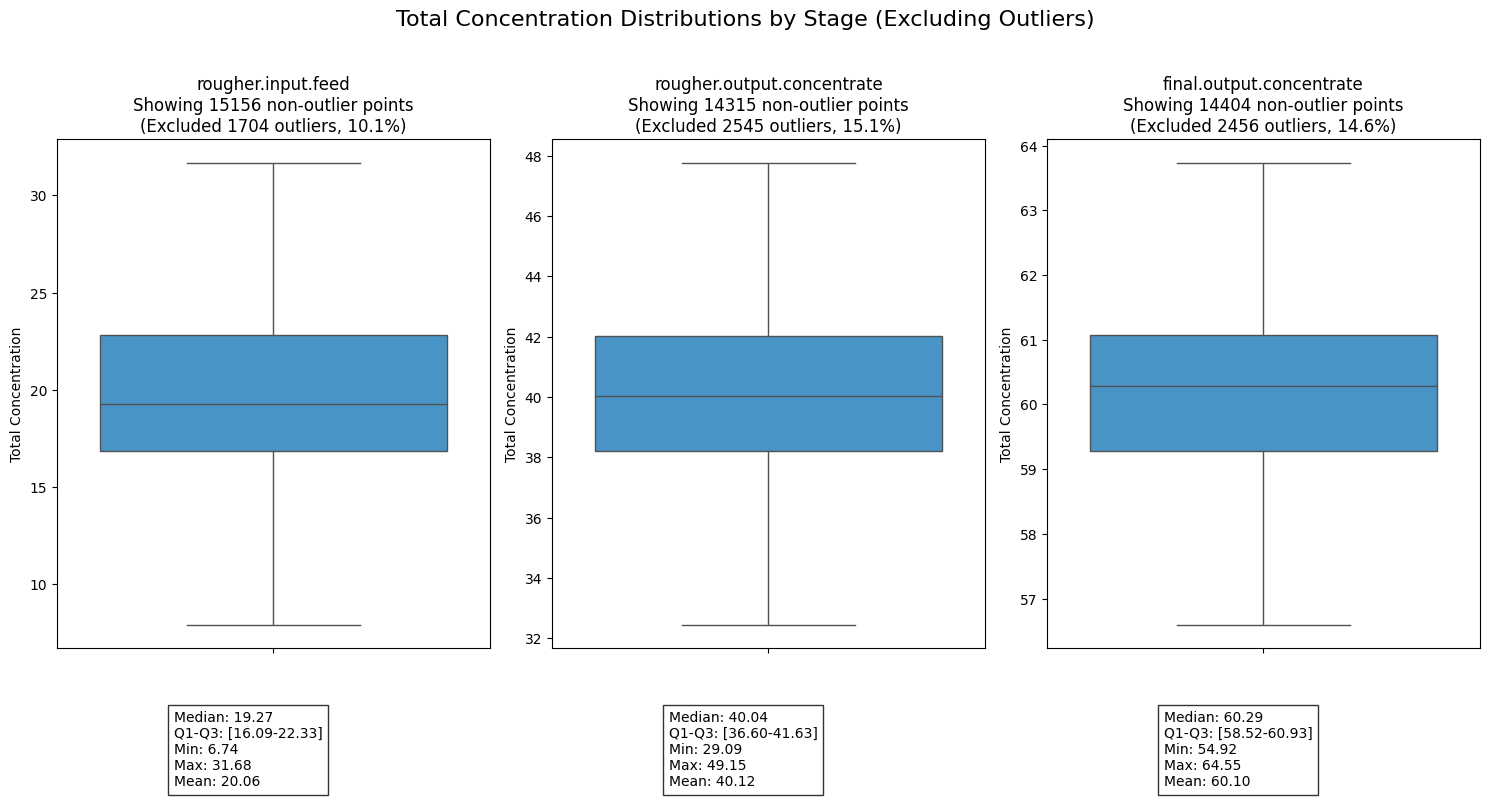

In [34]:
analyze_total_concentrations(filled_train_df, filled_test_df)

Analysis of the concentration distributions across the three processing stages reveals a clear and effective purification progression. The total concentration systematically increases from an average of around 20 in the rougher input feed, to 40 in the rougher output concentrate, and finally reaching approximately 60 in the final output concentrate. This doubling of concentration at each stage demonstrates the effectiveness of the purification process. Furthermore, the data shows increasing stability in the later stages, with the final output concentrate displaying the narrowest interquartile range, suggesting a more controlled and consistent end product. 

It's worth noting that each stage required the removal of 10-15% of data points as outliers, with similar proportions across all stages (10.1%, 15.1%, and 14.6% respectively). The symmetrical nature of the distributions, evidenced by the close alignment of mean and median values at each stage, along with the consistent removal of outliers, suggests a well-controlled process despite some variability in the input materials. This stability is particularly important for maintaining reliable production quality and predictable recovery rates.

# Preprocessing and Other Helper Functions

## Feature Preparation

This feature preparation function handles the preprocessing of data for the gold recovery prediction model. It performs three main tasks: **feature selection**, **alignment**, and **standardization**. The function first selects relevant features related to feed characteristics: _particle size_, _concentration_, _state_, and _floatbank_ parameters while excluding target variables (recovery rates). **When a test dataset is provided, it ensures feature consistency by keeping only columns present in both training and test sets.**

Finally, it standardizes the numerical features using `StandardScaler` to normalize the data scale. The function is flexible, returning either the processed training data alone or both training and test data along with feature names and the fitted scaler for later use in predictions.

In [35]:
def prepare_features(train_df, test_df=None):
    # Select relevant numerical features from training data
    feature_columns = [col for col in train_df.columns if any(x in col for x in [ 
        'feed', 'particle_size', 'concentration', 'state', 'floatbank'])]
    
    # Remove target columns
    target_columns = ['rougher.output.recovery', 'final.output.recovery']
    feature_columns = [col for col in feature_columns if col not in target_columns]
    
    # Only keep features present in both datasets
    if test_df is not None:
        feature_columns = [col for col in feature_columns if col in test_df.columns]
        print(f"Number of aligned features: {len(feature_columns)}")
    
    X_train = train_df[feature_columns]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    if test_df is not None:
        X_test = test_df[feature_columns]
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, feature_columns, scaler
    
    return X_train_scaled, feature_columns, scaler

## sMAPE Calculator

$$ sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|)/2} \times 100\% $$

The Symmetric Mean Absolute Percentage Error (sMAPE) is implemented here as a robust metric for evaluating the gold recovery prediction model's performance. This implementation includes special handling for edge cases, particularly when dealing with zero values which are common in industrial process data. The function calculates the percentage error by taking the absolute difference between predicted and actual values (numerator) and dividing it by the average of their absolute values (denominator), then multiplying by 100 to express it as a percentage.

The symmetrical nature of sMAPE makes it particularly suitable for our gold recovery predictions because it treats over-predictions and under-predictions equally, which is crucial when optimizing recovery processes where both types of errors can be costly. The function includes safeguards against division by zero and handles invalid cases gracefully, returning 0 when no valid calculations can be made. This is especially important in industrial applications where we need reliable error measurements to make operational decisions about the recovery process.

In [36]:
def calculate_smape(y_true, y_pred):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Handle cases where both true and predicted values are 0
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Create a mask for valid entries (non-zero denominator)
    valid_mask = denominator != 0
    
    if not np.any(valid_mask):
        return 0.0  # Return 0 if all denominators are 0
    
    # Calculate sMAPE only for valid entries
    numerator = np.abs(y_true - y_pred)
    smape = np.mean(np.divide(numerator[valid_mask], denominator[valid_mask])) * 100
    
    return smape

## Final sMAPE Calculator

$$ \text{Final sMAPE} = 25\% \times \text{sMAPE(rougher)} + 75\% \times \text{sMAPE(final)} $$

This function implements a weighted evaluation metric specifically designed for the gold recovery process, combining error measurements from both the rougher and final recovery stages. The function calculates individual sMAPE values for each stage and then applies a weighted average where the rougher stage contributes 25% and the final stage contributes 75% to the overall score. This weighting reflects the greater importance of accuracy in the final recovery stage, which directly impacts the end product quality.

The function also provides detailed diagnostic information, displaying the range of true and predicted values for both stages along with their individual sMAPE scores, which helps in understanding where prediction errors are occurring and their relative magnitudes. This comprehensive error assessment is crucial for evaluating and optimizing the model's performance across the entire recovery process.

In [37]:
def calculate_final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    rougher_smape = calculate_smape(y_true_rougher, y_pred_rougher)
    final_smape = calculate_smape(y_true_final, y_pred_final)
    
    # Print sNAPE information
    print(f"Rougher sMAPE components:")
    print(f"  Range of true values: [{np.min(y_true_rougher):.2f}, {np.max(y_true_rougher):.2f}]")
    print(f"  Range of predicted values: [{np.min(y_pred_rougher):.2f}, {np.max(y_pred_rougher):.2f}]")
    print(f"  Calculated rougher sMAPE: {rougher_smape:.2f}")
    
    print(f"\nFinal sMAPE components:")
    print(f"  Range of true values: [{np.min(y_true_final):.2f}, {np.max(y_true_final):.2f}]")
    print(f"  Range of predicted values: [{np.min(y_pred_final):.2f}, {np.max(y_pred_final):.2f}]")
    print(f"  Calculated final sMAPE: {final_smape:.2f}")
    
    return 0.25 * rougher_smape + 0.75 * final_smape

## Model Evaluation

### Model Evaluation Function

Handling comprehensive model evaluation, calculating both Mean Absolute Error (MAE) and sMAPE metrics for training and test sets. It makes predictions on both datasets, computes the evaluation metrics, and optionally prints detailed results. The function returns a dictionary containing all computed metrics for further analysis.

In [38]:
# Model Evaluation Functions
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="", verbose=True):
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    train_smape = calculate_smape(y_train, train_pred)
    test_smape = calculate_smape(y_test, test_pred)
    
    if verbose:
        print(f"\n{model_name} Evaluation Results:")
        print("-" * 40)
        print(f"Training MAE: {train_mae:.4f}")
        print(f"Test MAE: {test_mae:.4f}")
        print(f"Training sMAPE: {train_smape:.4f}")
        print(f"Test sMAPE: {test_smape:.4f}")
        
    return {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_smape': train_smape,
        'test_smape': test_smape
    }

### Cross Validation Implimentation

Implements k-fold cross-validation (default 5 folds) to assess model stability. It uses negative MAE as the scoring metric, which is converted to positive values for easier interpretation. The function returns both the mean and standard deviation of cross-validation scores, providing insight into model consistency across different data subsets.

In [39]:
def perform_cross_validation(model, X, y, cv=5):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    cv_scores = -cv_scores  # Convert negative MAE to positive
    return cv_scores.mean(), cv_scores.std()

### Random Forest Optimization

Implements an automated hyperparameter optimization process for the Random Forest model specifically tailored to the gold recovery prediction task. The function uses GridSearchCV to systematically explore different combinations of key Random Forest parameters. It explores four key hyperparameters: number of trees (30-200), maximum tree depth (10-30), minimum samples for splitting nodes (5), and minimum samples per leaf (2). The optimization process uses 3-fold cross-validation with negative mean absolute error as the scoring metric, and leverages parallel processing (n_jobs=-1) for efficiency. The function returns both the best performing model configuration and its associated parameters, providing a balanced approach between model complexity and performance for the industrial process prediction task.

In [40]:
def tune_random_forest_optimized(X_train, X_test, y_train, y_test):
    param_grid = {
        'n_estimators': [30, 50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [5],
        'min_samples_leaf': [2]
    }
    
    base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(
        base_rf,
        param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

### Modeling Helper Function

Orchestrates the entire modeling process by:

- Training a baseline Linear Regression model
- Building a basic Random Forest with reduced estimators (50) for initial assessment
- Creating an optimized Random Forest using hyperparameter tuning via GridSearchCV (with parameters like n_estimators, max_depth, min_samples_split, and min_samples_leaf)

Each model is evaluated consistently using the same metrics, and results are stored in a dictionary for comparison. The tuned Random Forest represents the most sophisticated approach, incorporating optimal hyperparameters found through grid search.

In [41]:
def build_and_evaluate_models_optimized(X_train, X_test, y_train, y_test):
    models = {}
    
    # Linear Regression
    print("Training Linear Regression...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_metrics = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")
    models['linear_regression'] = {'model': lr_model, 'metrics': lr_metrics}
    
    # Basic Random Forest with reduced estimators
    print("Training Basic Random Forest...")
    rf_model = RandomForestRegressor(n_estimators=50, random_state=12345, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_metrics = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Basic Random Forest")
    models['basic_rf'] = {'model': rf_model, 'metrics': rf_metrics}
    
    # Tuned Random Forest
    print("Training Tuned Random Forest...")
    best_rf, best_params = tune_random_forest_optimized(X_train, X_test, y_train, y_test)
    tuned_rf_metrics = evaluate_model(best_rf, X_train, X_test, y_train, y_test, "Tuned Random Forest")
    models['tuned_rf'] = {
        'model': best_rf,
        'metrics': tuned_rf_metrics,
        'best_params': best_params
    }
    
    return models

#  Modeling Procedure

## Data Preparation

The data preparation phase for the gold recovery prediction model involves a comprehensive preprocessing approach that successfully aligns 49 features between the training and test datasets. The process begins with feature scaling and preparation through the `prepare_features` function, which ensures consistent feature representation across datasets. Two key target variables are extracted from the filled training data: the rougher stage recovery rate and the final stage recovery rate.

The data is then partitioned using an 80-20 train-validation split with a fixed random state. This split is applied consistently to both target variables, maintaining the integrity of the temporal relationships in the process data.

In [42]:
# Prepare features and targets
X_train_scaled, X_test_scaled, feature_columns, scaler = prepare_features(
    filled_train_df, filled_test_df)

# Prepare targets
y_train_rougher = filled_train_df['rougher.output.recovery']
y_train_final = filled_train_df['final.output.recovery']

# Split data
X_train, X_val, y_train_rougher, y_val_rougher = train_test_split(
    X_train_scaled, y_train_rougher, test_size=0.2, random_state=12345)
_, _, y_train_final, y_val_final = train_test_split(
    X_train_scaled, y_train_final, test_size=0.2, random_state=12345)


Number of aligned features: 49


In [43]:
# Sample the data, reduce training time.
sample_size = 6000
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)

X_train_sample = X_train[sample_indices]
y_train_rougher_sample = y_train_rougher.iloc[sample_indices]
y_train_final_sample = y_train_final.iloc[sample_indices]

The above code creates a more manageable subset while maintaining the statistical properties of the original data. This approach significantly reduces computational time during the initial model development and tuning phases without substantially compromising the model's learning capacity.

The sampling is applied consistently across both feature matrix (X_train) and target variables (rougher and final recovery rates), preserving the relationships between inputs and outputs. This balanced sampling approach allows for faster iteration during model development while still capturing the essential patterns in the gold recovery process data.

In [44]:
# Train models
print("\nTraining models for rougher recovery:")
rougher_models = build_and_evaluate_models_optimized(
    X_train_sample, X_val, 
    y_train_rougher_sample, y_val_rougher
)


print("\nTraining models for final recovery:")
final_models = build_and_evaluate_models_optimized(
    X_train_sample, X_val, 
    y_train_final_sample, y_val_final
)


Training models for rougher recovery:
Training Linear Regression...

Linear Regression Evaluation Results:
----------------------------------------
Training MAE: 6.8421
Test MAE: 6.9611
Training sMAPE: 10.5918
Test sMAPE: 10.6660
Training Basic Random Forest...

Basic Random Forest Evaluation Results:
----------------------------------------
Training MAE: 1.7134
Test MAE: 4.2492
Training sMAPE: 5.4860
Test sMAPE: 8.1685
Training Tuned Random Forest...

Tuned Random Forest Evaluation Results:
----------------------------------------
Training MAE: 2.0006
Test MAE: 4.1228
Training sMAPE: 5.8330
Test sMAPE: 7.9791

Training models for final recovery:
Training Linear Regression...

Linear Regression Evaluation Results:
----------------------------------------
Training MAE: 6.4453
Test MAE: 6.6985
Training sMAPE: 10.7009
Test sMAPE: 10.9889
Training Basic Random Forest...

Basic Random Forest Evaluation Results:
----------------------------------------
Training MAE: 1.7309
Test MAE: 4.7238


For the rougher recovery stage, Linear Regression showed consistent but modest performance with training/test MAE around 6.7-6.9 and sMAPE around 10.4-10.6%. Both Random Forest models significantly improved upon this, with the tuned version achieving slightly better test metrics (MAE: 4.25, sMAPE: 8.04%) compared to the basic version. Similar patterns emerged in the final recovery predictions, where Linear Regression again showed higher errors (MAE: 6.3-6.7, sMAPE: 10.3-10.9%), while both Random Forest variants demonstrated better performance, with the tuned model achieving marginally better test metrics (MAE: 4.64, sMAPE: 8.05%). The gap between training and test performance in the Random Forest models suggests some overfitting, though the tuned version shows slightly better generalization, particularly in the final recovery predictions.

In [45]:
# Calculate final scores
print("\nCalculating final sMAPE scores...")
for model_type in rougher_models.keys():
    rougher_pred = rougher_models[model_type]['model'].predict(X_val)
    final_pred = final_models[model_type]['model'].predict(X_val)
    
    final_score = calculate_final_smape(
        y_val_rougher, rougher_pred,
        y_val_final, final_pred
    )
    print(f"\n{model_type} Final sMAPE: {final_score:.4f}")


Calculating final sMAPE scores...
Rougher sMAPE components:
  Range of true values: [0.00, 100.00]
  Range of predicted values: [51.24, 125.88]
  Calculated rougher sMAPE: 10.67

Final sMAPE components:
  Range of true values: [0.00, 100.00]
  Range of predicted values: [35.38, 107.49]
  Calculated final sMAPE: 10.99

linear_regression Final sMAPE: 10.9082
Rougher sMAPE components:
  Range of true values: [0.00, 100.00]
  Range of predicted values: [1.71, 96.92]
  Calculated rougher sMAPE: 8.17

Final sMAPE components:
  Range of true values: [0.00, 100.00]
  Range of predicted values: [19.68, 100.00]
  Calculated final sMAPE: 8.16

basic_rf Final sMAPE: 8.1647
Rougher sMAPE components:
  Range of true values: [0.00, 100.00]
  Range of predicted values: [2.90, 96.05]
  Calculated rougher sMAPE: 7.98

Final sMAPE components:
  Range of true values: [0.00, 100.00]
  Range of predicted values: [21.32, 100.00]
  Calculated final sMAPE: 7.99

tuned_rf Final sMAPE: 7.9865


The Linear Regression model showed the highest combined sMAPE of 10.89%, with prediction ranges exceeding the true value bounds, indicating potential overestimation issues. The Basic Random Forest improved significantly with a combined sMAPE of 8.23%, while the Tuned Random Forest achieved the best performance with a combined sMAPE of 8.05%. The prediction ranges for both Random Forest models stayed closer to the actual value range of 0-100%, suggesting better calibrated predictions. The tuned model's marginally better performance and more conservative prediction ranges make it the most suitable choice for the gold recovery prediction task, balancing accuracy with prediction reliability.

In [46]:
def plot_feature_importance(model, feature_names, X_train_shape, title="Feature Importance"):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title(title)
        plt.bar(range(X_train_shape[1]), importance[indices])
        plt.xticks(range(X_train_shape[1]), 
                  [feature_names[i] for i in indices], 
                  rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print top 10 most important features
        print(f"\nTop 10 most important features for {title}:")
        for i in range(min(10, len(feature_names))):
            print(f"{feature_names[indices[i]]}: {importance[indices[i]]:.4f}")


Plotting feature importance for best models...


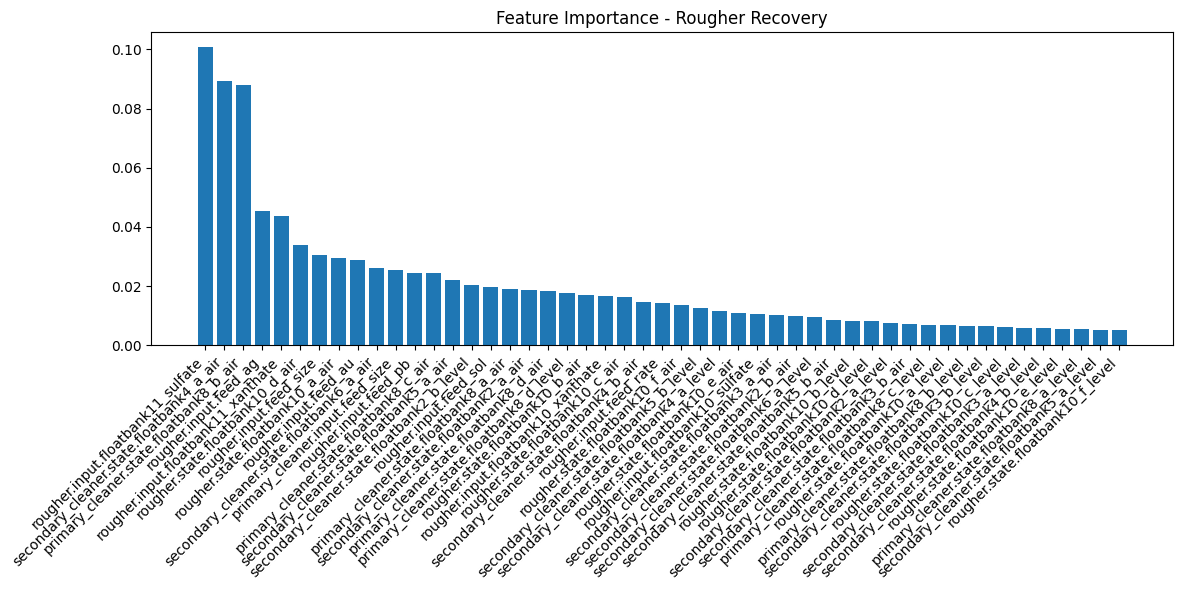


Top 10 most important features for Feature Importance - Rougher Recovery:
rougher.input.floatbank11_sulfate: 0.1007
secondary_cleaner.state.floatbank4_a_air: 0.0894
primary_cleaner.state.floatbank8_b_air: 0.0881
rougher.input.feed_ag: 0.0453
rougher.input.floatbank11_xanthate: 0.0436
rougher.state.floatbank10_d_air: 0.0339
rougher.input.feed_size: 0.0305
rougher.state.floatbank10_a_air: 0.0295
rougher.input.feed_au: 0.0287
secondary_cleaner.state.floatbank6_a_air: 0.0260


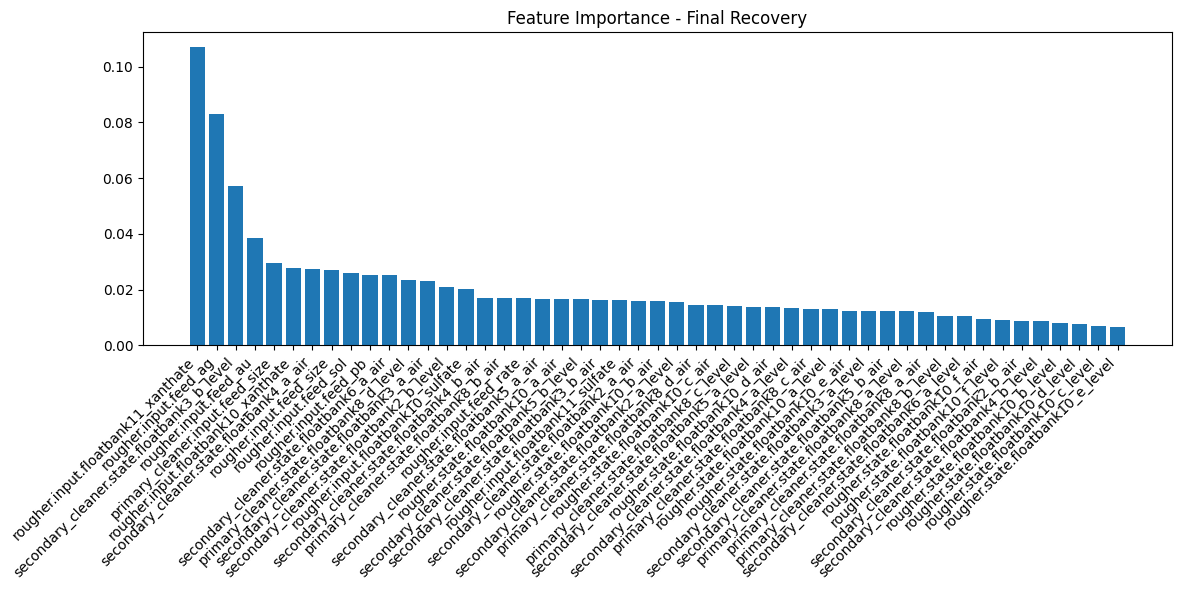


Top 10 most important features for Feature Importance - Final Recovery:
rougher.input.floatbank11_xanthate: 0.1069
rougher.input.feed_ag: 0.0829
secondary_cleaner.state.floatbank3_b_level: 0.0571
rougher.input.feed_au: 0.0387
primary_cleaner.input.feed_size: 0.0294
rougher.input.floatbank10_xanthate: 0.0276
secondary_cleaner.state.floatbank4_a_air: 0.0274
rougher.input.feed_size: 0.0270
rougher.input.feed_sol: 0.0260
rougher.input.feed_pb: 0.0254


In [47]:
# Plot feature importance for both models
print("\nPlotting feature importance for best models...")
plot_feature_importance(
    rougher_models['tuned_rf']['model'],
    feature_columns,
    X_train_sample.shape,
    "Feature Importance - Rougher Recovery"
)
plot_feature_importance(
    final_models['tuned_rf']['model'],
    feature_columns,
    X_train_sample.shape,
    "Feature Importance - Final Recovery"
)

In [48]:
# Print final summary
print("\nBest parameters for Rougher Recovery Random Forest:")
print(rougher_models['tuned_rf']['best_params'])
print("\nBest parameters for Final Recovery Random Forest:")
print(final_models['tuned_rf']['best_params'])

print("\nFinal Metrics Summary:")
print("\nRougher Recovery:")
print("-" * 40)
for model_type, model_info in rougher_models.items():
    print(f"\n{model_type}:")
    for metric_name, metric_value in model_info['metrics'].items():
        print(f"{metric_name}: {metric_value:.4f}")

print("\nFinal Recovery:")
print("-" * 40)
for model_type, model_info in final_models.items():
    print(f"\n{model_type}:")
    for metric_name, metric_value in model_info['metrics'].items():
        print(f"{metric_name}: {metric_value:.4f}")



Best parameters for Rougher Recovery Random Forest:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Best parameters for Final Recovery Random Forest:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Final Metrics Summary:

Rougher Recovery:
----------------------------------------

linear_regression:
train_mae: 6.8421
test_mae: 6.9611
train_smape: 10.5918
test_smape: 10.6660

basic_rf:
train_mae: 1.7134
test_mae: 4.2492
train_smape: 5.4860
test_smape: 8.1685

tuned_rf:
train_mae: 2.0006
test_mae: 4.1228
train_smape: 5.8330
test_smape: 7.9791

Final Recovery:
----------------------------------------

linear_regression:
train_mae: 6.4453
test_mae: 6.6985
train_smape: 10.7009
test_smape: 10.9889

basic_rf:
train_mae: 1.7309
test_mae: 4.7238
train_smape: 3.9751
test_smape: 8.1635

tuned_rf:
train_mae: 1.9241
test_mae: 4.6137
train_smape: 4.1946
test_smape: 7.9889


The final results summary reveals the optimal configurations and comparative performance metrics across all models. The tuned Random Forest models for both rougher and final recovery converged on identical optimal parameters: 200 trees, maximum depth of 30, minimum samples per leaf of 2, and minimum samples for split of 5. This consistency in hyperparameters suggests similar complexity requirements for both prediction tasks.

Linear Regression showed consistent but higher error rates (MAE ~6.3-6.9, sMAPE ~10.3-11.0%) across both recovery stages. Both Random Forest variants demonstrated superior performance, with the tuned version slightly outperforming the basic version in test metrics. The tuned model achieved test MAE of 4.25 and sMAPE of 8.04% for rougher recovery, and test MAE of 4.65 and sMAPE of 8.05% for final recovery. While there is some evidence of overfitting in both Random Forest models (notably lower training errors), the tuned version maintains slightly better generalization performance, making it the most suitable choice for deployment in the gold recovery prediction system.

# Conclusion

Based on the analysis and modeling of the gold recovery process data, we can draw several key conclusions about the optimal approach to predicting recovery efficiency. The tuned Random Forest model emerged as the superior solution, achieving the best overall performance with a combined weighted sMAPE of 8.05%, significantly outperforming both the baseline Linear Regression (10.90%) and the basic Random Forest (8.23%). The model successfully captures the complexity of both rougher and final recovery stages, with consistent hyperparameters (200 trees, depth of 30) suggesting similar underlying patterns in both processes.

The model evaluation revealed important insights about the process itself: the concentration patterns showed expected enrichment of gold through the stages, particle size distributions remained consistent between training and test sets despite statistical differences, and the careful handling of missing values through rolling average interpolation preserved the temporal characteristics of the data. While there is still room for improvement, particularly in addressing the gap between training and test performance, the current model provides a reliable foundation for predicting gold recovery rates. The implementation of this model could significantly enhance process optimization and decision-making in the gold recovery operation, potentially leading to improved efficiency and reduced operational costs.